In [4]:
from skimage.graph import pixel_graph
from trajectory_predictor.utils.PixelGraph import PixelGraph
import numpy as np

binary_mask = np.array([[1, 1, 1, 0, 0],
                       [0, 1, 0, 1, 0],
                       [0, 1, 0, 1, 0],
                       [0, 1, 1, 1, 0],
                       [0, 0, 0, 0, 0]])
pg = PixelGraph(binary_mask)

print(pg.adj(0), pg.dist(0, 6))
print(np.unravel_index(6, binary_mask.shape))
center = (1, 1)
radius = 2
lower_i = max(center[0] - radius, 0)
upper_i = min(center[0] + radius, binary_mask.shape[0])
lower_j = max(center[1] - radius, 0)
upper_j = min(center[1] + radius, binary_mask.shape[1])

selection = binary_mask[lower_i:upper_i, lower_j:upper_j]
indexes = np.where(selection)
original_index = np.ravel_multi_index((lower_i + indexes[0], lower_j + indexes[1]), binary_mask.shape)
print(original_index, selection)

nodes = np.ravel_multi_index(np.where(binary_mask > 0), binary_mask.shape)
print(nodes)

# pg = PixelGraph(binary_mask)
# graph, nodes = pixel_graph(binary_mask > 0, mask=None, edge_function=None, connectivity=10)
# pg.graph = graph
# pg.nodes = nodes

# pg.adj(12)
np.unravel_index(24, (5, 5))

[1 6] 1.4142135623730951


NameError: name 'fsadf' is not defined

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from trajectory_predictor.utils.PixelGraph import PixelGraph
# Doing pretreatment

# Load map image
map_path = './maps/real_map/better_map.pgm'
img = cv2.imread(map_path, cv2.IMREAD_GRAYSCALE)
crop = img[850:1100,800:1000]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


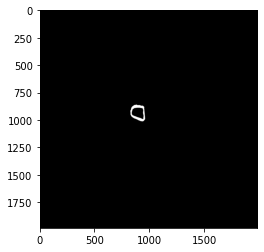

In [47]:
%load_ext autoreload
%autoreload 2
from trajectory_predictor.utils.mapping import filter_track_on_image

img = filter_track_on_image('./maps/real_map/better_map')
plt.imshow(img, cmap='gray')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[ 98.0100092   97.65371803  97.65371803 ... 186.24465192 185.37149453
 185.16428889]


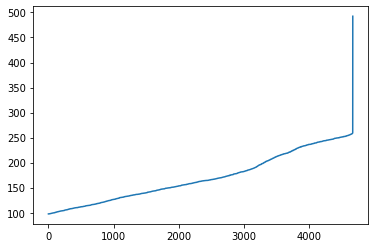

In [3]:
%load_ext autoreload
%autoreload 2
from trajectory_predictor.utils.mapping import pixel_graph_to_spanning_tree_and_missing_links, missing_links_and_tree_to_centerline

graph = PixelGraph(crop == 0, radius=3)
pixels, links = pixel_graph_to_spanning_tree_and_missing_links(graph)
path = missing_links_and_tree_to_centerline(links, pixels)
nodes = np.array(path)
# nodes = np.array(pixels.nodes)
unravelled_nodes = np.unravel_index(nodes, crop.shape)
selected_nodes = np.zeros_like(crop)
selected_nodes[unravelled_nodes] = 255
crop_weak = crop.copy()*0.3 + selected_nodes*0.7
# cv2.fillPoly(crop_weak, [path], (255, 255, 255))
# plt.imshow(crop_weak, cmap='gray')

In [41]:
from trajectory_predictor.utils.mapping import pixel_graph_to_spanning_tree_and_missing_links, missing_links_and_tree_to_bigger_loop

nodes = graph.get_nodes()
visited_nodes = set()

paths = []

for node in nodes:
    if node in visited_nodes:
        continue
    pg, links = pixel_graph_to_spanning_tree_and_missing_links(graph, node)
    if len(pg.nodes) < 100:
        continue
    [visited_nodes.add(node) for node in pg.nodes]

    path = missing_links_and_tree_to_centerline(links, pg)
    print(len(pg.nodes))
    paths.append(path)
    

1160
1162


KeyboardInterrupt: 

In [12]:
def path_to_filled_image(path):
    crop_weak = np.zeros_like(crop)
    two_d_indexes = np.unravel_index(path, crop.shape)
    arr = np.array(two_d_indexes).T
    arr[:, 0], arr[:, 1] = arr[:, 1].copy(), arr[:, 0].copy()
    cv2.fillPoly(crop_weak, pts=[arr], color=255)
    return crop_weak
path_filled_images = [path_to_filled_image(path) for path in paths]

heer


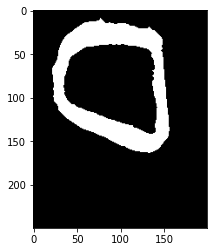

In [31]:
def simplify_images(images):
    # compare each pair of images
    # if they are similar, merge them
    # if they are different, keep them separate

    image_set = []
    print("heer")
    for image in images:
        found_close_image = False
        for i in range(len(image_set)):
            image_set_item = image_set[i]
            if np.sum(image != image_set_item) < 1000:
                found_close_image = True
                image[image != image_set_item] = 0
                image_set[i] = image
        if not found_close_image:
            image_set.append(image)
    return image_set
s = simplify_images(path_filled_images)
plt.imshow(s[0]-s[1], cmap='gray')

197
239
156
188
188
188
188


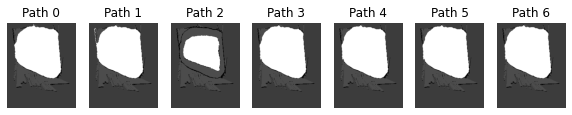

In [31]:

# one ax fo each path
def viz_pixels(ax, path):
    path_nodes = np.array(path)
    print(len(path_nodes))
    unravelled_nodes = np.unravel_index(path_nodes, crop.shape)
    selected_nodes = np.zeros_like(crop)
    selected_nodes[unravelled_nodes] = 255
    crop_weak = crop.copy()*0.3 + selected_nodes*0.7
    # ax.imshow(crop_weak, cmap='gray')
    two_d_indexes = np.unravel_index(path, crop.shape)
    # print(np.array(two_d_indexes))
    arr = np.array(two_d_indexes).T
    arr[:, 0], arr[:, 1] = arr[:, 1].copy(), arr[:, 0].copy()
    cv2.fillPoly(crop_weak, pts=[arr], color=(255, 255, 255))
    ax.imshow(crop_weak, cmap='gray')

fig, axs = plt.subplots(1, len(paths), figsize=(10, 10))
for i, path in enumerate(paths):
    viz_pixels(axs[i], path)
    axs[i].set_title('Path {}'.format(i))
    axs[i].axis('off')

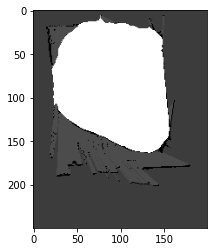

In [17]:
crop_weak = crop.copy()*0.3 + selected_nodes*0.7
two_d_indexes = np.unravel_index(path, crop.shape)
# print(np.array(two_d_indexes))
arr = np.array(two_d_indexes).T
arr[:, 0], arr[:, 1] = arr[:, 1].copy(), arr[:, 0].copy()
cv2.fillPoly(crop_weak, pts=[arr], color=(255, 255, 255))
plt.imshow(crop_weak, cmap='gray')

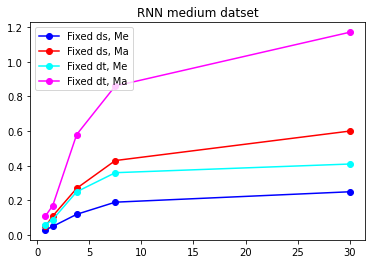

In [13]:
import matplotlib.pyplot as plt

series1 = [0.03, 0.05, 0.12, 0.19, 0.25]
series2 = [0.05, 0.11, 0.27, 0.43, 0.60]
series3 = [0.06, 0.09, 0.25, 0.36, 0.41]
series4 = [0.11, 0.17, 0.58, 0.86, 1.17]
horizon = [0.8, 1.5, 3.8, 7.5, 30]

legend1 = 'Fixed ds, Me'
legend2 = 'Fixed ds, Ma'
legend3 = 'Fixed dt, Me'
legend4 = 'Fixed dt, Ma'

plt.plot(horizon, series1, 'o-', label=legend1, color='blue')
plt.plot(horizon, series2, 'o-', label=legend2, color='red')
plt.plot(horizon, series3, 'o-', label=legend3, color='cyan')
plt.plot(horizon, series4, 'o-', label=legend4, color='magenta')
plt.title('RNN medium datset')
# legend on top left
plt.legend(loc='upper left')
# save as pgf
plt.savefig('rnn_medium_dataset.pgf')

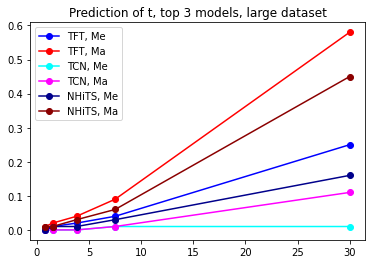

In [18]:
import matplotlib.pyplot as plt

series1 = [0.00, 0.01, 0.02, 0.04, 0.25]
series2 = [0.01, 0.02, 0.04, 0.09, 0.58]
series3 = [0.00, 0.00, 0.00, 0.01, 0.01]
series4 = [0.00, 0.00, 0.00, 0.01, 0.11]
series5 = [0.00, 0.01, 0.01, 0.03, 0.16]
series6 = [0.01, 0.01, 0.03, 0.06, 0.45]
horizon = [0.8, 1.5, 3.8, 7.5, 30]

legend1 = 'TFT, Me'
legend2 = 'TFT, Ma'
legend3 = 'TCN, Me'
legend4 = 'TCN, Ma'
legend5 = 'NHiTS, Me'
legend6 = 'NHiTS, Ma'

plt.plot(horizon, series1, 'o-', label=legend1, color='blue')
plt.plot(horizon, series2, 'o-', label=legend2, color='red')
plt.plot(horizon, series3, 'o-', label=legend3, color='cyan')
plt.plot(horizon, series4, 'o-', label=legend4, color='magenta')
plt.plot(horizon, series5, 'o-', label=legend5, color='darkblue')
plt.plot(horizon, series6, 'o-', label=legend6, color='darkred')
plt.title('Prediction of t, top 3 models, large dataset')
# legend on top left
plt.legend(loc='upper left')
# save as pgf
plt.savefig('top_t.pgf')